## **Disclaimer!**
This notebook is meant to be used by anyone interested in replicating our model or playing around with the data. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1kUTkGI89PJRl0dVy79xIZuH9Qokl9Stq) and store it on your own Google Drive. By clicking on the folder name "Thesis_LucaThoms" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

## **Setup**

Loading in required packages, setting up devices (e.g., cuda), and mounting Google Drive for data/model access

In [1]:
import os
import json
import random
import time
import cv2
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.figure_factory as ff
from keras.utils import to_categorical
from matplotlib import colors
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torchvision
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using a {device.type} device.")

You are using a cpu device.


In [2]:
# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/Thesis_LucaThoms/'

Mounted at /content/drive


## **Helper Functions**

Various helper functions, assisting with plotting, padding, scaling, one-hot encoding, and augmentation of tasks.

In [3]:
def plot_one(task, ax, i, train_or_test, input_or_output='representation'):
    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    if input_or_output == 'representation':
        input_matrix = task
    elif input_or_output == 'prediction':
        input_matrix = test_predictions[i]
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' ' + input_or_output)

# For single ARC matrices use the following for plotting:
# plot_one(X, ax=None, i=None, train_or_test='anything', input_or_output='single')

def plot_task(task, idx):   
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i], i, 'train', 'input')
        plot_one(task, axs[1,i], i, 'train', 'output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    num_outp = len(task['test'][0])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test == 1: 
        plot_one(task, axs[0], 0, 'test', 'input')
        if num_outp > 1:
            plot_one(task, axs[1], 0, 'test', 'output')  
        elif 'test_predictions' in locals() or 'test_predictions' in globals():
            plot_one(task, axs[1], idx, 'test', 'prediction')
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i], i, 'test', 'input')
            plot_one(task, axs[1,i], i, 'test', 'output')  
    plt.tight_layout()
    plt.show() 

def plot_ARC(example_num = None, path = 'training'):
    idx = random.randint(0, 99) if example_num is None else example_num

    task_file = f'{eval(path + "_path")}{(eval(path + "_tasks_files"))[idx]}'
    with open(task_file, 'r') as f:
        example = json.load(f)

    plot_task(example, idx)

def plot_pix_acc(X_inp, X_out):
    raw_diff = []
    for i in range(len(X_inp)):
        raw_diff.append(np.count_nonzero(X_inp[i] == X_out[i]))
    per_diff = [x / 900 for x in raw_diff]
    m = np.mean(per_diff)

    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(per_diff, color='steelblue', marker='.', linewidth=0)
    plt.axhline(m, xmax = len(per_diff), color='firebrick')
    plt.title(f'Accuracy of Task Representation (Tasks:{len(per_diff)})', size='large')
    plt.xlabel('Case')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(per_diff)/2, m+0.02, f'{m.round(2)*100}%', size='large', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.margins(x=0.01)
    plt.show()
    print(f'Number of 100% Correct Representations: {per_diff.count(1)}')
    print(f'Number of 90%+ Correct Representations: {sum(i >= 0.9 for i in per_diff)}')
    print(f'Number of 80%+ Correct Representations: {sum(i >= 0.8 for i in per_diff)}')
    print(f'Number of 70%+ Correct Representations: {sum(i >= 0.7 for i in per_diff)}')

def plot_pix_heatmap(X_inp, X_out):
    pix_diff = []
    for i in range(len(X_inp)):
        pix_diff.append(X_inp[i] == X_out[i])

    pix_sum = np.sum(pix_diff, axis=0)

    fig, ax = plt.subplots(figsize=(7,7)) 
    heatmap = sns.heatmap(pix_sum, cmap='inferno_r', square=True) # oder viridis_r
    plt.title('Accuracy of Individual Pixel Representation', size='large', y=1.04)
    plt.text(0.2, 32, f'Number of 100% Correct Pixels: {np.count_nonzero((pix_sum == len(X_inp)))}', size='large')
    plt.axis('off')
    plt.show()

In [42]:
def padding(X, height=30, width=30):
    h = X.shape[0]
    w = X.shape[1]

    a = (height - h) // 2
    aa = height - a - h

    b = (width - w) // 2
    bb = width - b - w

    return np.pad(X, pad_width=((a, aa), (b, bb)), mode='constant')

def scaling(X, height=30, width=30):
    h = height/X.shape[0]
    w = width/X.shape[1]
    d = np.floor(min(h, w)).astype(int)
      
    X_scaled = np.kron(X, np.ones((d, d)))
    # X_scaled = np.kron(X, np.ones((np.floor(h).astype(int),
    #                                np.floor(w).astype(int))))
    
    return padding(X_scaled, height, width).astype(int)

def one_hot_encoder(X):
    one_hot = (np.arange(10) == X[..., None]).astype(int)
    
    return np.transpose(one_hot, axes = [2, 0, 1])

def reverse_one_hot_encoder(X):
    one_hot_rev = np.argmax(np.transpose(X, axes=[1,2,0]), axis=-1)

    return one_hot_rev

def replace_values(X, dic):
    return np.array([dic.get(i, -1) for i in range(X.min(), X.max() + 1)])[X - X.min()]

def get_all_matrix(X_full):
    X_fill = []
    for X_task in X_full:
        for X_single in X_task:
            X_fill.append(np.array(X_single))
    
    return X_fill

def get_final_matrix(X_full, stage="."):
    if stage != "train":
        X_full = get_all_matrix(X_full)

    X_full_mat = []
    for i in range(len(X_full)):
        X_sca = scaling(X_full[i], 30, 30)
        X_one = one_hot_encoder(X_sca)
        X_full_mat.append(X_one)

    return X_full_mat

def augment_color(X_full, y_full):
    X_flip = []
    y_flip = []
    for X, y in zip(X_full, y_full): 
        X_rep = np.tile(X, (10, 1, 1))
        X_flip.append(X_rep[0])
        y_rep = np.tile(y, (10, 1, 1))
        y_flip.append(y_rep[0])
        for i in range(1, len(X_rep)):
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dic = dict(zip(orig, rep))
            X_flip.append(replace_values(X_rep[i], dic))
            y_flip.append(replace_values(y_rep[i], dic))

    return X_flip, y_flip

def augment_rotate(X_full, y_full):
    X_rot = []
    y_rot = []
    for X, y in zip(X_full, y_full):
        k = random.randint(0, 4)
        X_rot.append(np.rot90(X, k))
        y_rot.append(np.rot90(y, k))
    
    return X_rot, y_rot

def preprocess_matrix(X_full, y_full, aug=[True, True]):
    X_full = get_all_matrix(X_full)
    y_full = get_all_matrix(y_full)

    if aug[0]:
        print("Augmentation: Random Color Flipping")
        X_full, y_full = augment_color(X_full, y_full)
    
    if aug[1]:
        print("Augmentation: Random Rotation")
        X_full, y_full = augment_rotate(X_full, y_full)

    return X_full, y_full

def convo_eff(w = 30, num = 1, k = 3, p = 0, s = 1):
    for i in range(num):
        w = ((w - k + (2*p))/s) + 1

    return w

## **Load Data**

Loading in the JSON files containing the raw tasks. Tasks are encoded as matrices divided into train/test and input/output sections, containing numbers 0-9 which describe the color palette (e.g., red, orange). The below code makes use of this internal structure to access the train and test data in separate objects.

In [5]:
training_path = f'{our_data_dir}Data/data_training/'
evaluation_path = f'{our_data_dir}Data/data_evaluation/'
test_path = f'{our_data_dir}Data/data_test/'

training_tasks_files = sorted(os.listdir(training_path))
evaluation_tasks_files = sorted(os.listdir(evaluation_path))
test_tasks_files = sorted(os.listdir(test_path))

In [6]:
training_tasks = []
for task_file in training_tasks_files:
    with open(f'{training_path}{task_file}', 'r') as f:
        task = json.load(f)
        training_tasks.append(task)

# Example
training_tasks[3]["train"][0]["output"]

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 6, 6, 6, 0, 0, 0, 0],
 [0, 0, 6, 0, 0, 6, 0, 0, 0],
 [0, 0, 0, 6, 0, 0, 6, 0, 0],
 [0, 0, 0, 0, 6, 0, 6, 0, 0],
 [0, 0, 0, 0, 6, 6, 6, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 2, 2, 2, 2, 0, 0],
 [0, 0, 0, 2, 0, 0, 2, 0, 0],
 [0, 0, 0, 2, 2, 2, 2, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [11]:
X_test, X_train, y_train = [], [], []

for task in training_tasks:
    Xs_test, Xs_train, ys_train = [], [], []

    for pair in task["test"]:
        Xs_test.append(pair["input"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test.append(Xs_test)
    X_train.append(Xs_train)
    y_train.append(ys_train)

matrices = get_all_matrix(X_test)

# Example
X_test[3]

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 4, 4, 4, 4, 4, 4, 0, 0, 0],
  [0, 4, 0, 0, 0, 0, 0, 4, 0, 0],
  [0, 0, 4, 0, 0, 0, 0, 0, 4, 0],
  [0, 0, 0, 4, 0, 0, 0, 0, 0, 4],
  [0, 0, 0, 0, 4, 4, 4, 4, 4, 4],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

## **Exploration**

Exploring the features of the tasks visually: Means, Distributions, Skews.

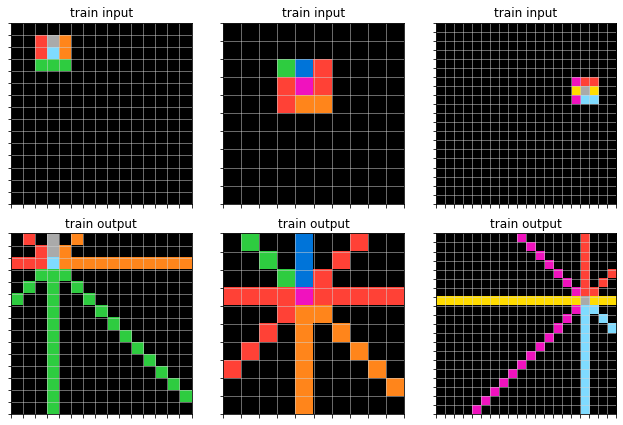

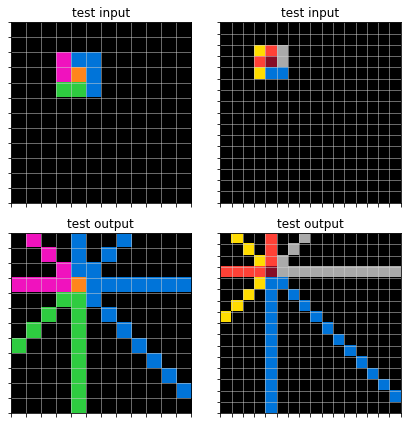

In [ ]:
plot_ARC(49, path = "evaluation")

In [ ]:
means = [np.mean(matrix) for matrix in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

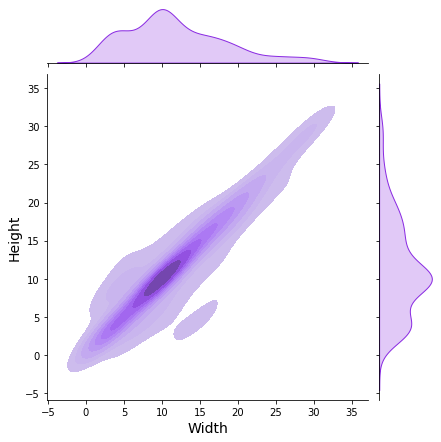

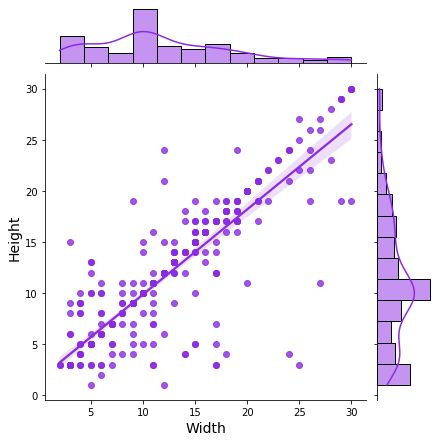

In [ ]:
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]

plot = sns.jointplot(x=widths, y=heights, kind="kde", fill=True, thresh = 0.09, color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

plot = sns.jointplot(x=widths, y=heights, kind="reg", color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

## **PyTorch Dataset**

Preparing the data for the PyTorch framework and applying transformations (e.g., scaling)

In [44]:
# Load in Dataset (incl. Augmentations, Padding)
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train", aug=[True, True]):
        self.stage = stage

        if self.stage == "train":
            self.X, self.y = preprocess_matrix(X, y, aug)
            self.X = get_final_matrix(self.X, self.stage)
            self.y = get_final_matrix(self.y, self.stage)
        else:
            self.X = get_final_matrix(X, self.stage)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inp = self.X[idx]
        inp = torch.tensor(inp, dtype=torch.float32)

        if self.stage == "train":
            outp = self.y[idx]
            outp = torch.tensor(outp, dtype=torch.float32)

        return inp, outp

In [70]:
# Showcase Padding, One-Hot Encoding, Dimensionality, and Augmentation with regards to Colors
train_set = ARCDataset(X_train, y_train, stage="train", aug=[True, True])

fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(5):
    idx = random.randrange(len(train_set.X))
    plot_one(reverse_one_hot_encoder(train_set.X[idx]), axs[0,i], i, 'input')
    plot_one(reverse_one_hot_encoder(train_set.y[idx]), axs[1,i], i, 'output')

Augmentation: Random Color Flipping


## **Embeddings: Variational Autoencoder**

In [17]:
convo_eff(w=30, num=3, k=3)

24.0

In [18]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, img_channels=10, feature_dim=[64, 24, 24], latent_dim=64): # Alternatives 32*22*22
        super(VariationalAutoencoder, self).__init__()

        self.f_dim = feature_dim

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, 
                      out_channels=256, 
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, 
                      out_channels=128, 
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=64, 
                      kernel_size=3),
            nn.ReLU())#,
            # nn.Conv2d(in_channels=64, 
            #           out_channels=32, 
            #           kernel_size=3),
            # nn.ReLU())
        self.fc_mu = nn.Linear(np.prod(self.f_dim), latent_dim)
        self.fc_var = nn.Linear(np.prod(self.f_dim), latent_dim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.dec_inp = nn.Linear(latent_dim, np.prod(self.f_dim))
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(in_channels=32, 
            #                    out_channels=64, 
            #                    kernel_size=3),
            # nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=256, 
                               kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=img_channels, 
                               kernel_size=3),
            nn.Sigmoid())

    def encode(self, x):
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encoder(x)
        x = x.view(-1, np.prod(self.f_dim))
        mu = self.fc_mu(x)
        logVar = self.fc_var(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.dec_inp(z)
        x = x.view(-1, self.f_dim[0], self.f_dim[1], self.f_dim[2])
        x = self.decoder(x)
        return x.squeeze()

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar

## **Training**

In [19]:
# Define batch size, create dataloaders and initialize network
batch_size = 128

train_set = ARCDataset(X_train, y_train, stage="train", aug=[True, True])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

vae = VariationalAutoencoder().to(device)

# Training the network for a given number of epochs (loss after every epoch is printed)
def train(model, train_loader, epochs=20):
    optimizer = Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        for batch_idx, data in enumerate(train_loader):
            input, _ = data
            input = input.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar 
            out, mu, logVar = model(input)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
            # print(out.shape, inputs.shape)
            loss = F.binary_cross_entropy(out, input, size_average=False) + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch {}: Loss {}'.format(epoch+1, loss))
    
    return model

vae_final = train(vae, train_loader, epochs=50)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1: Loss 181550.734375
Epoch 2: Loss 151942.109375
Epoch 3: Loss 140090.6875
Epoch 4: Loss 120628.6328125
Epoch 5: Loss 100497.796875
Epoch 6: Loss 85655.625
Epoch 7: Loss 75513.46875
Epoch 8: Loss 75028.1328125
Epoch 9: Loss 55960.3828125
Epoch 10: Loss 63356.87890625
Epoch 11: Loss 56750.40625
Epoch 12: Loss 52254.7734375
Epoch 13: Loss 45996.25
Epoch 14: Loss 49864.9375
Epoch 15: Loss 50118.1328125
Epoch 16: Loss 46128.9375
Epoch 17: Loss 35953.1171875
Epoch 18: Loss 54421.8203125
Epoch 19: Loss 46433.94921875
Epoch 20: Loss 36478.95703125
Epoch 21: Loss 41661.14453125
Epoch 22: Loss 41834.78125
Epoch 23: Loss 42562.046875
Epoch 24: Loss 34255.171875
Epoch 25: Loss 42873.0078125
Epoch 26: Loss 36846.4375
Epoch 27: Loss 40878.82421875
Epoch 28: Loss 32864.0078125
Epoch 29: Loss 41032.71484375
Epoch 30: Loss 34752.9609375
Epoch 31: Loss 36120.6875
Epoch 32: Loss 34759.625
Epoch 33: Loss 38480.34375
Epoch 34: Loss 34838.28515625
Epoch 35: Loss 31679.501953125
Epoch 36: Loss 33604.

## **Building**

In [21]:
# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/model_64.pt', map_location=torch.device(device))

In [22]:
X_inp = []
X_out = []

model_vae.eval()
with torch.no_grad():
    for idx, data in enumerate(train_loader):
        input, _ = data
        input = input.to(device)
        out, mu, logVAR = model_vae(input)
        for i in range(len(input)):
            X_inp.append(reverse_one_hot_encoder(input[i].cpu().numpy()))
            X_out.append(reverse_one_hot_encoder(out[i].cpu().numpy()))

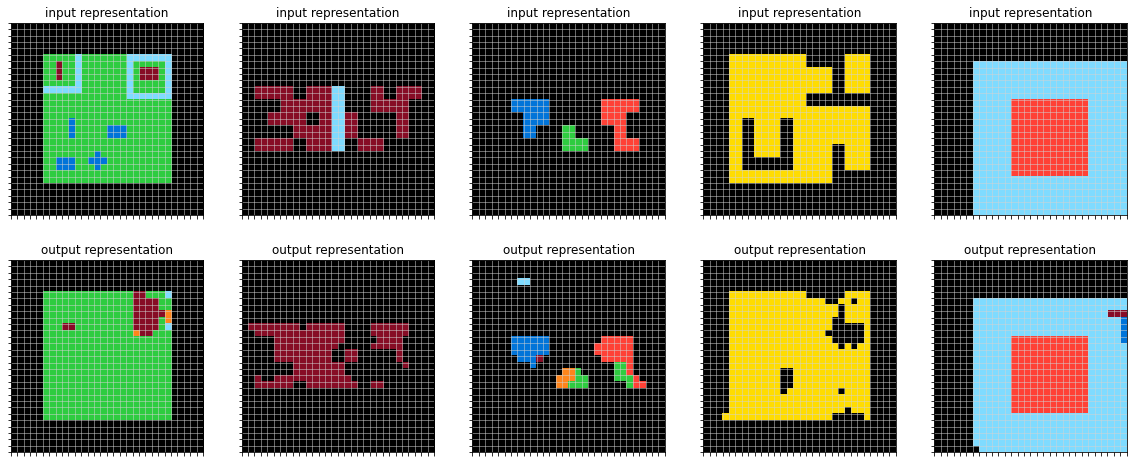

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(5):
    idx = random.randrange(len(X_inp))
    plot_one(X_inp[idx], axs[0,i], i, 'input')
    plot_one(X_out[idx], axs[1,i], i, 'output')

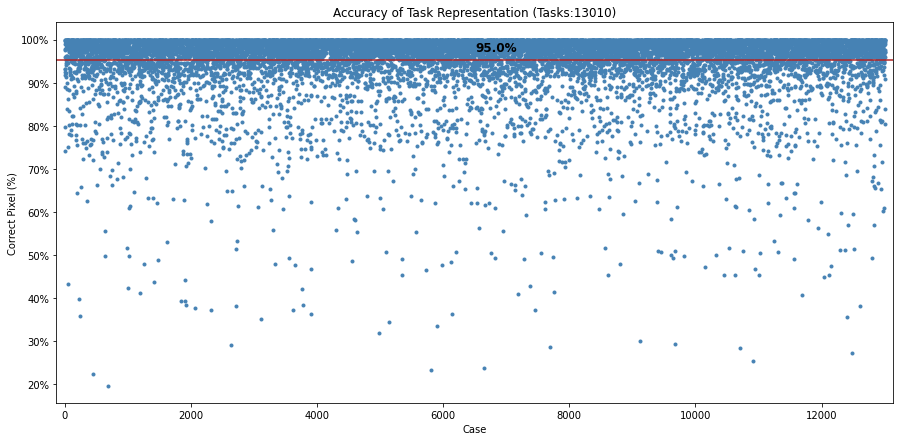

Number of 100% Correct Representations: 1510
Number of 90%+ Correct Representations: 11496
Number of 80%+ Correct Representations: 12386
Number of 70%+ Correct Representations: 12776


In [33]:
# Plot differences be tween input and output matrices
plot_pix_acc(X_inp, X_out)

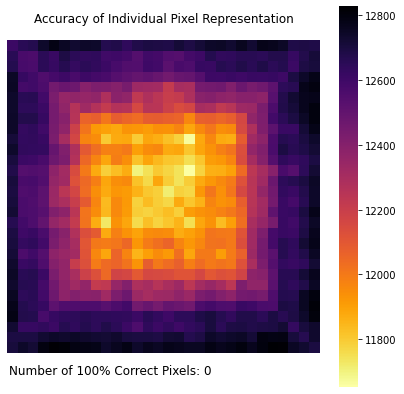

In [32]:
# Plot heatmap of correct pixel determination by the model (absolute)
plot_pix_heatmap(X_inp, X_out)

## **Predictions**

In [20]:
## Saving models
# torch.save(vae_final, '/content/drive/MyDrive/Thesis_LucaThoms/model.pt')
# model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/model.pt', map_location=torch.device(device.type))

## Saving predictions
# with open('example_pred.pkl', 'wb') as f:
#   pickle.dump(test_predictions, f)

# Loading saved predictions
# with open('/content/drive/MyDrive/Thesis_LucaThoms/example_pred.pkl', 'rb') as f:
#     test_predictions = pickle.load(f)

## **Archive**

In [ ]:
def replace_values(a, d):
    return np.array([d.get(i, -1) for i in range(a.min(), a.max() + 1)])[a - a.min()]

def repeat_matrix(X):
    return np.concatenate([X]*((1000 // len(X)) + 1))[:1000]

def get_new_matrix(X):
    if len(set([np.array(x).shape for x in X])) > 1:
        X = np.array([X[0]])
    return X

def get_ind_matrix(X):
    X_mat = []
    if len(set([np.array(x).shape for x in X])) > 1:
        X_ls = list([np.array(x).shape for x in X])
        max_ls = [max(X_ls, key=lambda x:x[i])[i] for i in range(2)]
        for i in range(len(X)):
            X_pad = padding(np.array(X[i]), max_ls[0], max_ls[1])
            X_mat.append(X_pad)
    else:
        for i in range(len(X)):
            X_mat.append(np.array(X[i]))
    return X_mat

def get_outp(outp, dictionary=None, replace=True):
    if replace:
        outp = replace_values(outp, dictionary)

    outp_matrix_dims = outp.shape
    outp_probs_len = outp.shape[0]*outp.shape[1]*10
    outp = to_categorical(outp.flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

def transform_dim(inp_dim, outp_dim, test_dim):
    return (test_dim[0]*outp_dim[0]/inp_dim[0],
            test_dim[1]*outp_dim[1]/inp_dim[1])

def resize(x, test_dim, inp_dim):
    if inp_dim == test_dim:
        return x
    else:
        return cv2.resize(flt(x), inp_dim, interpolation=cv2.INTER_AREA)

def flt(x): return np.float32(x)
def npy(x): return x.cpu().detach().numpy()
def itg(x): return np.int32(np.round(x))

In [ ]:
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train"):
        self.X = get_new_matrix(X)
        self.X = repeat_matrix(X)
        
        self.stage = stage
        if self.stage == "train":
            self.y = get_new_matrix(y)
            self.y = repeat_matrix(y)
        
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        inp = self.X[idx]
        if self.stage == "train":
            outp = self.y[idx]

        if idx != 0:
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dictionary = dict(zip(orig, rep))
            inp = replace_values(inp, dictionary)
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, dictionary)
                
        if idx == 0:
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, None, False)
        
        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train"):
        self.X = get_ind_matrix(X)
        self.stage = stage
        if self.stage == "train":
            self.y = get_ind_matrix(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        inp = self.X[idx]
        if self.stage == "train":
            outp = self.y[idx]
            outp, outp_probs_len, outp_matrix_dims = get_outp(outp, None, False)
        
        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

In [ ]:
class BasicCNNModel(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(BasicCNNModel, self).__init__()
        
        Conv_In = 3
        Conv_Out_1 = 50
        Conv_Out_2 = 100
        Kernel = 3
        Dense_In = Conv_Out_2
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(Dense_In, outp_dim[0]*outp_dim[1]*10)
        
        if inp_dim[0] < 5 or inp_dim[1] < 5:
            Kernel = 1

        self.conv2d_1 = nn.Conv2d(Conv_In, Conv_Out_1, kernel_size=Kernel)
        self.conv2d_2 = nn.Conv2d(Conv_Out_1, Conv_Out_2, kernel_size=Kernel)

    def forward(self, x, outp_dim):
        x = torch.cat([x.unsqueeze(0)]*3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv2d_1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv2d_1(x))
        self.conv2d_2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2d_2(conv_1_out))
        
        self.dense_1.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense_1(feature_vector)
        
        out = []
        for idx in range(logit_outputs.shape[1]//10):
            out.append(self.softmax(logit_outputs[:, idx*10: (idx+1)*10]))
        return torch.cat(out, axis=1)

class ARCModel(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(ARCModel, self).__init__()

        kernel = 3
        if inp_dim[0] < 5 or inp_dim[1] < 5:
            kernel = 1
        
        self.input_shape = inp_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=(kernel,kernel), padding='same')
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(kernel,kernel), padding='same')
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dense = nn.Linear(in_features=100, out_features=(outp_dim[0]*outp_dim[1]*10))


    def forward(self, x, outp_dim):
        x = torch.cat([x.unsqueeze(0)]*3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv1(x))
        self.conv2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2(conv_1_out))
        
        self.dense.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense(feature_vector)
        
        out = []
        for idx in range(logit_outputs.shape[1]//10):
            out.append(self.softmax(logit_outputs[:, idx*10: (idx+1)*10]))
        return torch.cat(out, axis=1)

class VariationalAutoencoder(nn.Module):

    def __init__(self, 
                 in_channels: int, 
                 latent_dim: int, 
                 layer_dim: int,
                 hidden_dims: List = None,
                 kernel_size: List = None, 
                 **kwargs) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = [128] * layer_dim

        if kernel_size is None:
            kernel_size = list(range(1, (layer_dim + 1)))

        # Build Encoder
        modules = []
        for i in range(len(hidden_dims)):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, 
                              hidden_dims[i],
                              kernel_size=kernel_size[i], 
                              stride=2, 
                              padding=1),
                    nn.BatchNorm2d(hidden_dims[i]),
                    nn.LeakyReLU())
            )
            in_channels = hidden_dims[i]

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()
        kernel_size.reverse()
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=kernel_size[i],
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=kernel_size[-1],
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], 
                                      3,
                                      kernel_size=kernel_size[-1], 
                                      padding=1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': kld_loss.detach()}

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

class ConvEncoder(nn.Module):
    def __init__(self):
        super(ConvEncoder, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(10, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 128, 3, stride=2, padding=1)

        # Fully-connected layers
        self.fc1 = nn.Linear(4*4*32, 256)
        self.fc2 = nn.Linear(256, 128)

        # Nonlinearities
        self.relu = nn.ReLU()

        # Initialize parameters
        for name, param in self.named_parameters():
            # Initialize all biases to 0
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            # Initialize all pre-ReLU weights using Kaiming normal distribution
            elif 'weight' in name:
                nn.init.kaiming_normal_(param, nonlinearity='relu')

    def forward(self, x):
        # Convolutional layers
        conv1_out = self.relu(self.conv1(x))
        conv2_out = self.relu(self.conv2(conv1_out))
        conv3_out = self.relu(self.conv3(conv2_out))

        # Flatten output of conv net
        conv3_out_flat = torch.flatten(conv3_out, 1)

        # Fully-connected layers
        fc1_out = self.relu(self.fc1(conv3_out_flat))
        fc2_out = self.relu(self.fc2(fc1_out))

        # Output
        z = fc2_out
        return z


class ESBN(nn.Module):
    def __init__(self, norm_type='contextnorm'):
        super(ESBN, self).__init__()

        # Task Specifications
        seq_len = 4
        y_dim = 30*30

        # Encoder
        self.encoder = ConvEncoder()

        # LSTM and output layers
        self.z_size = 128
        self.key_size = 256
        self.hidden_size = 512
        self.lstm = nn.LSTM(self.key_size + 1, self.hidden_size, batch_first=True)
        self.key_w_out = nn.Linear(self.hidden_size, self.key_size)
        self.g_out = nn.Linear(self.hidden_size, 1)
        self.confidence_gain = nn.Parameter(torch.ones(1))
        self.confidence_bias = nn.Parameter(torch.zeros(1))
        self.y_out = nn.Linear(self.hidden_size, y_dim)

        # Context normalization
        if norm_type == 'contextnorm':
            self.contextnorm = True
            self.task_seg = [np.arange(seq_len)]
            self.gamma = nn.Parameter(torch.ones(self.z_size))
            self.beta = nn.Parameter(torch.zeros(self.z_size))
        else:
            self.contextnorm = False
            
        # Nonlinearities
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Initialize parameters
        for name, param in self.named_parameters():
            # Encoder parameters have already been initialized
            if not ('encoder' in name) and not ('confidence' in name):
                # Initialize all biases to 0
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                else:
                    if 'lstm' in name:
                        # Initialize gate weights (followed by sigmoid) using Xavier normal distribution
                        nn.init.xavier_normal_(param[:self.hidden_size*2,:])
                        nn.init.xavier_normal_(param[self.hidden_size*3:,:])
                        # Initialize input->hidden and hidden->hidden weights (followed by tanh) using Xavier normal distribution with gain = 
                        nn.init.xavier_normal_(param[self.hidden_size*2:self.hidden_size*3,:], gain=5.0/3.0)
                    elif 'key_w' in name:
                        # Initialize weights for key output layer (followed by ReLU) using Kaiming normal distribution
                        nn.init.kaiming_normal_(param, nonlinearity='relu')
                    elif 'g_out' in name:
                        # Initialize weights for gate output layer (followed by sigmoid) using Xavier normal distribution
                        nn.init.xavier_normal_(param)
                    elif 'y_out' in name:
                        # Initialize weights for multiple-choice output layer (followed by softmax) using Xavier normal distribution
                        nn.init.xavier_normal_(param)

    def forward(self, x_seq, device):
        # Encode all images in sequence
        z_seq = []
        mat_dim = x_seq.shape[2], x_seq.shape[2]//3 
        for i in range(0, mat_dim[0], mat_dim[1]):
            for j in range(0, mat_dim[0], mat_dim[1]):
                x_t = x_seq[:,:,i:i+mat_dim[1],j:j+mat_dim[1]]
                z_t = encoder(x_t)
                z_seq.append(z_t)
        z_seq = torch.stack(z_seq, dim=1)
        if self.contextnorm:
            z_seq_all_seg = [self.apply_context_norm(z_seq[:,self.task_seg[0],:])]
            z_seq = torch.cat(z_seq_all_seg, dim=1)
        # Initialize hidden state
        hidden = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
        cell_state = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
        # Initialize retrieved key vector
        key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
        # Memory model (extra time step to process key retrieved on final time step)
        for t in range(z_seq.shape[1] + 1):
            # Image embedding
            if t == z_seq.shape[1]:
                z_t = torch.zeros(x_seq.shape[0], 1, self.z_size).to(device)
            else:
                z_t = z_seq[:,t,:].unsqueeze(1)
            # Controller
            # LSTM
            lstm_out, (hidden, cell_state) = self.lstm(key_r, (hidden, cell_state))
            # Key output layers
            key_w = self.relu(self.key_w_out(lstm_out))
            # Gates
            g = self.sigmoid(self.g_out(lstm_out))
            # Task output layer
            y_pred_linear = self.y_out(lstm_out).squeeze()
            y_pred = y_pred_linear.argmax(1)
            # Read from memory
            if t == 0:
                key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
            else:
                # Read key
                w_k = self.softmax((z_t * M_v).sum(dim=2))
                c_k = self.sigmoid(((z_t * M_v).sum(dim=2) * self.confidence_gain) + self.confidence_bias)
                key_r = g * (torch.cat([M_k, c_k.unsqueeze(2)], dim=2) * w_k.unsqueeze(2)).sum(1).unsqueeze(1)
            # Write to memory
            if t == 0:
                M_k = key_w
                M_v = z_t
            else:
                M_k = torch.cat([M_k, key_w], dim=1)
                M_v = torch.cat([M_v, z_t], dim=1)
        return y_pred_linear, y_pred
    
    def apply_context_norm(self, z_seq):
        eps = 1e-8
        z_mu = z_seq.mean(1)
        z_sigma = (z_seq.var(1) + eps).sqrt()
        z_seq = (z_seq - z_mu.unsqueeze(1)) / z_sigma.unsqueeze(1)
        z_seq = (z_seq * self.gamma) + self.beta
        return z_seq

In [ ]:
Batch_Size = 1
Epochs = 50

idx = 0
start = time.time()
test_predictions = []

for Xs_train, ys_train in zip(X_train, y_train):
    print("TASK " + str(idx + 1))

    train_set = ARCDataset(Xs_train, ys_train, stage="train")
    train_loader = DataLoader(train_set, batch_size=Batch_Size, shuffle=True)

    inp_dim = np.array(get_matrix(Xs_train)).shape[1:]
    outp_dim = np.array(get_matrix(ys_train)).shape[1:]
    network = ARCModel(inp_dim, outp_dim).cuda()
    optimizer = Adam(network.parameters(), lr=0.01)
    
    for epoch in range(Epochs):
        for train_batch in train_loader:
            train_X, train_y, out_d, d, out = train_batch
            train_preds = network.forward(train_X.cuda(), out_d.cuda())
            train_loss = nn.MSELoss()(train_preds, train_y.cuda())
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

    end = time.time()        
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    Xs_test = np.array([resize(flt(X), np.shape(X), inp_dim) for X in X_test[idx-1]])
    for X in Xs_test:
        test_dim = np.array(torch.Tensor(X)).shape
        test_preds = npy(network.forward(torch.Tensor(X).unsqueeze(0).cuda(), out_d.cuda()))
        test_preds = np.argmax(test_preds.reshape((10, *outp_dim)), axis=0)
        test_predictions.append(itg(resize(test_preds, np.shape(test_preds),
                                           tuple(itg(transform_dim(inp_dim, outp_dim, test_dim))))))
    idx += 1